# Exercise 11) Policy Gradients

In this exercise we will have a look at policy gradients. 
The theory of policy gradients applies to function approximators that decide on which action to choose. 
The function approximators we met in the past were employed to estimate the (action) value function. 
Since their task was to judge the quality of the current situation they are often referred to as "critics". 
In contrary, we can also use a function approximator to directly choose an action; we call these "actors". 
Why should we do that if we made it work with nothing more than a critic? 
Because this will finally allow us to make use of contiuous action spaces! Eureka!

In this exercise we will use a new `gym` environment `LunarLanderContinuous-v2`.
To run this environment please make sure to have `Box2D` installed: `pip install Box2D`.

![](https://images.squarespace-cdn.com/content/v1/59e0d6f0197aea1a0abc8016/1507938542206-41S6K9T97YETKEHP0PQF/ke17ZwdGBToddI8pDm48kMR1yAHb8bPoH1-OdajP2rZZw-zPPgdn4jUwVcJE1ZvWQUxwkmyExglNqGp0IvTJZUJFbgE-7XRK3dMEBRBhUpyDg3tXaPHS4cFkn9Bnm-emI0BDr_E-XKAFKqWrx68ZVlLyhCgVi_FJvVMH7mHrc18/lunar_lander_success_example.gif?format=500w)

Source: https://www.billyvreeland.com/portfolio/2017/1013/solving-openai-gym-nm4yz

The main task is to land the LunarLander in the landing zone.
An accident-free landing is defined by both legs coming into  ground contact with moderate velocity.
We are dealing with a continuous state and action space as defined below.
Please notice that the control functions for main and side engines contain a dead zone in which the engines are inactive.
The reward is mainly defined depending on whether the landing procedure is successful (+100) or not (-100).
Firing the main engine gives a small negative reward. 
The problem is solved if a return of at least 200 is reached. 
For more information see https://gymnasium.farama.org/environments/box2d/lunar_lander/.




\begin{align}
\text{state}&=
\begin{bmatrix}
p_x\\
p_y\\
v_x\\
v_y\\
\varphi\\
20 \, \omega\\
1 \text{ if left leg has ground contact, else } 0\\
1 \text{ if right leg has ground contact, else } 0\\
\end{bmatrix}
\\
\text{action}&=
\begin{bmatrix}
\text{main engine: } [-1, 0] \rightarrow \text{off}, ]0, 1] \rightarrow [50 \, \%, 100 \, \%] \text{ of available power}\\
\text{side engines: } [-1, -0.5] \rightarrow [50 \, \%, 100 \, \%] \text{ of available right engine power}, [0.5, 1] \rightarrow [50 \, \%, 100 \, \%] \text{ of available left engine power}\\
\end{bmatrix}
\end{align}

In [1]:
import numpy as np
import pandas as pd
import gymnasium as gym
import random
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import deque
from sklearn.kernel_approximation import RBFSampler
import sklearn.pipeline
import sklearn.preprocessing

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Lambda, Input
from tensorflow.keras.optimizers import SGD

In [2]:
env = gym.make("LunarLander-v2",
                continuous=True,
              render_mode = "human")

state = env.reset()
while True:
    state, reward, terminated, truncated, _ = env.step(env.action_space.sample())
    done = terminated or truncated

    if done:
        break
env.close()

## 1) Monte Carlo Policy Gradient
Write a REINFORCE algorithm.

Execute the follwoing cell to fit the featurizer using RBFSampler, like already learned in the last exercises. 

In [3]:
env = gym.make("LunarLander-v2",
                continuous=True)
state_array = []
state = env.reset()

for i in tqdm(range(1000)):
    state, _ = env.reset()
    while True:
        state, reward, terminated, truncated, _ = env.step(env.action_space.sample())
        done = terminated or truncated
        state_array.append(state)

        if done:
            break

state_array = np.array(state_array)

featurizer = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.pipeline.FeatureUnion([
    ("rbf0", RBFSampler(gamma=5.0, n_components = 1000)),
    ("rbf1", RBFSampler(gamma=2.0, n_components = 1000)),
    ("rbf2", RBFSampler(gamma=1.0, n_components = 1000)),
    ("rbf3", RBFSampler(gamma=0.5, n_components = 1000)),
    ]),
    sklearn.preprocessing.StandardScaler()
)

_ = featurizer.fit(state_array)
env.close()


  0%|          | 0/1000 [00:00<?, ?it/s]

Use the following cell to define the function approximators for the policy.
As seen in Algo.12.1 we need to calculate $\nabla_\theta \mathrm{ln}\,\pi(u_k | x_k, \theta)$.
$\pi$ is herein defined as the normal distribution : 
\begin{align}
\pi(u_k | x_k, \theta) & = \frac{\mathrm{exp} \left( {-\frac{1}{2} (u_k - \mu_\theta(x_k))^\mathrm{T} \mathbf{\Sigma}^{-1}_\theta(x_k) (u_k - \mu_\theta(x_k))} \right)}{\sqrt{(2\pi)^p \mathrm{det}(\mathbf{\Sigma}_\theta(x_k))}},\\
\text{with}\hspace{1em} p & = \mathrm{dim}(u_k).
\end{align}

Extend `loglikelyhoodGaussian` such that it returns $\mathrm{ln}\,\pi(u_k | x_k, \theta)$! 
Use the numpy equivalent `TensorFlow` functions (e.g. `tf.linalg.inv()`).
`TensorFlow` functions are differentiable and can therefore be  used to calculate $\nabla_\theta \mathrm{ln}\,\pi(u_k | x_k, \theta)$.


In [4]:
env = gym.make("LunarLander-v2",
                continuous=True)

state = np.reshape(env.reset()[0], (1, -1))
feature_state = featurizer.transform(state)
input_dim = feature_state.shape[1]
action_space_dim = len(env.action_space.sample())


# define policy
def create_policy():
    input_layer = Input(shape=input_dim)
    
    hidden1 = Dense(400, activation='linear')(input_layer)
    hidden1 = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden1)
        
    hidden2_mu = Dense(400, activation='linear')(hidden1)
    hidden2_mu = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden2_mu)
    
    hidden2_sigma = Dense(400, activation='linear')(hidden1)
    hidden2_sigma = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden2_sigma)
    
    mu_out = Dense(action_space_dim, activation='linear')(hidden2_mu)
    mu_out = Lambda(lambda x: tf.reshape(tf.clip_by_value(x, -1, 1), (-1, 1)))(mu_out)
    sigma_out = Dense(action_space_dim, activation='softplus')(hidden2_sigma)
    sigma_out = Lambda(lambda x: tf.linalg.diag(tf.clip_by_value(tf.reshape((x @ np.array([[0.01, 0], [0, 0.1]])), [-1]), 1e-4, 1)))(sigma_out)
    
    policy = Model(inputs=input_layer, outputs=[mu_out, sigma_out])
    
    return policy

policy = create_policy()
theta = policy.get_weights()

# Regularization; downscaling of the network parameters to prevent divergence
for i in range(len(theta)):
    theta[i] = theta[i] * 0.4

policy.set_weights(theta)

@tf.function
def loglikelyhoodGaussian(x, arg_mu, arg_sigma):
    x = tf.cast(x, tf.float32)
    
    ### BEGIN SOLUTION
    
    dim = len(x)
    x_min_mu = x - arg_mu
    gaussian_exponent = - 0.5 * tf.transpose(x_min_mu) @ tf.linalg.inv(arg_sigma) @ (x_min_mu)
    det = tf.linalg.det(arg_sigma)
    gaussian_factor = -tf.math.log(tf.sqrt((2 * np.pi) ** dim * det))
    return gaussian_factor + gaussian_exponent

    ### END SOLUTION


Use the following template to write a REINFORCE algorithm.
This time the Adam (adaptive moment estimation) optimizer is used, which is an enhanced SGD optimizer.
For more informations see https://arxiv.org/abs/1412.6980.

  0%|          | 0/5000 [00:00<?, ?it/s]

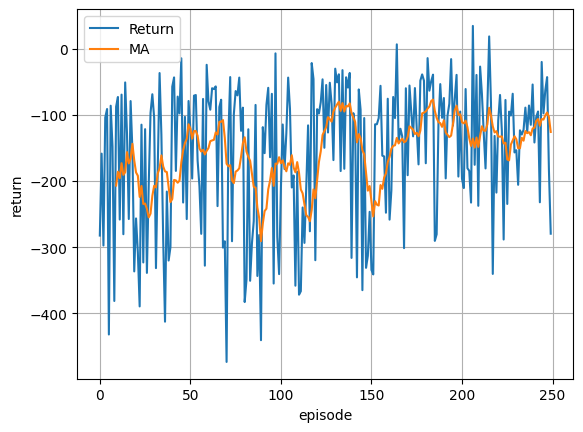

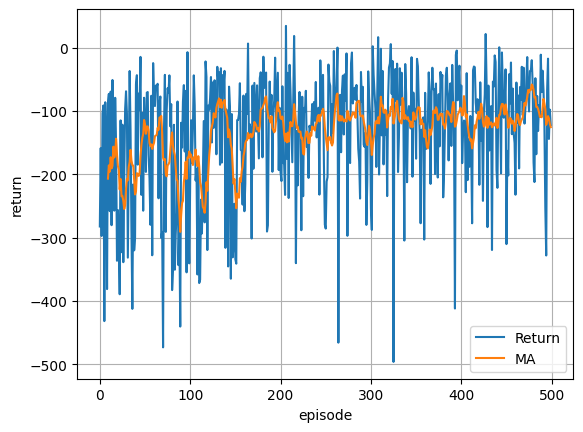

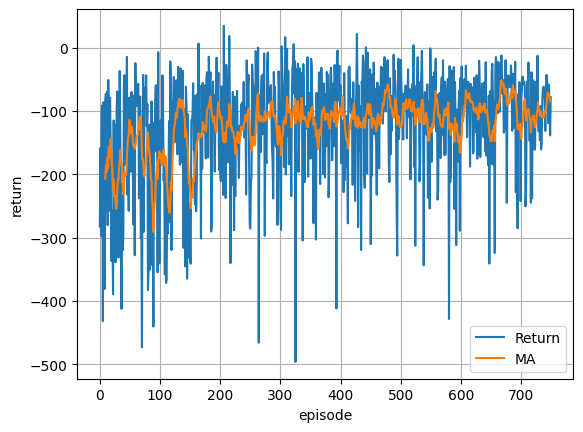

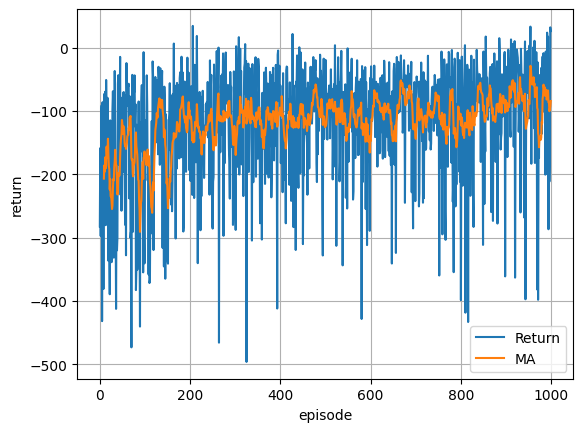

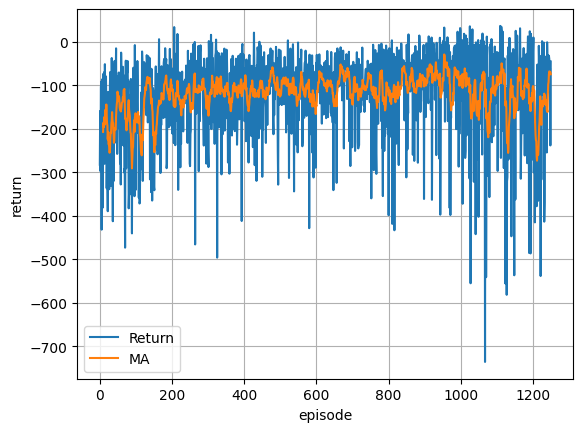

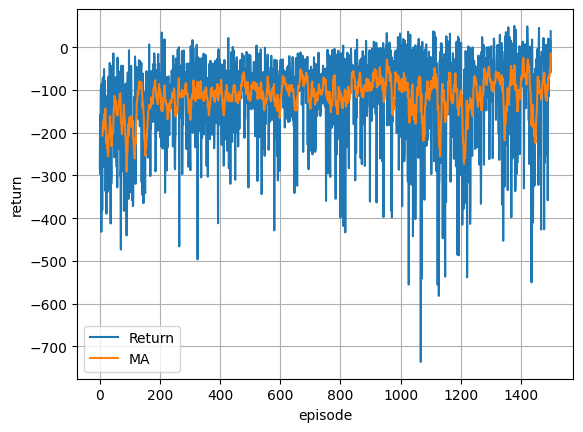

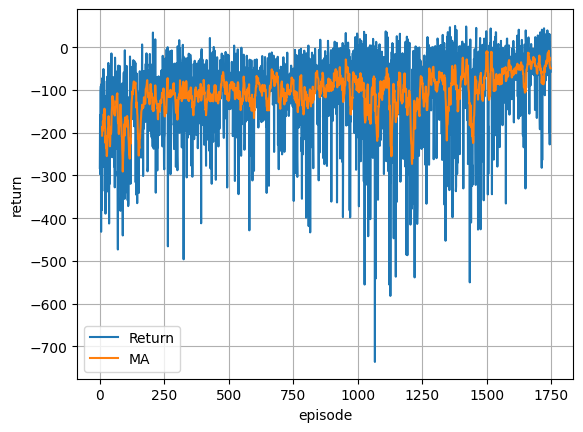

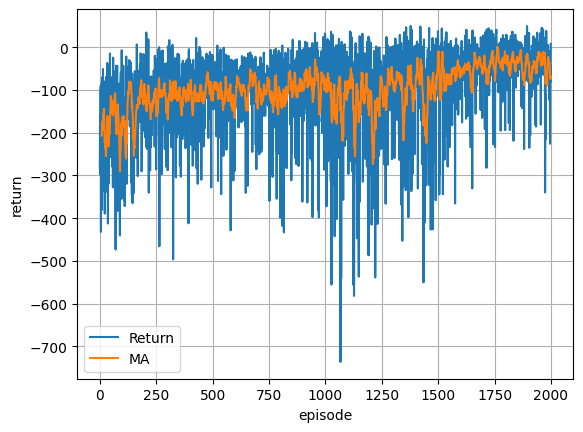

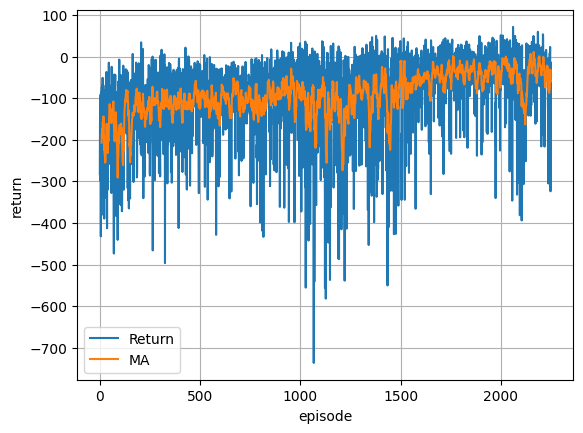

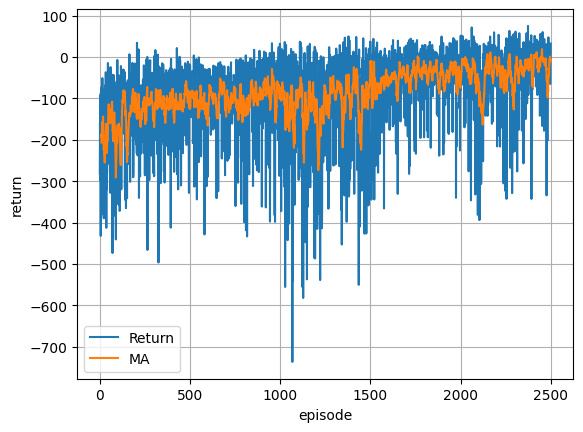

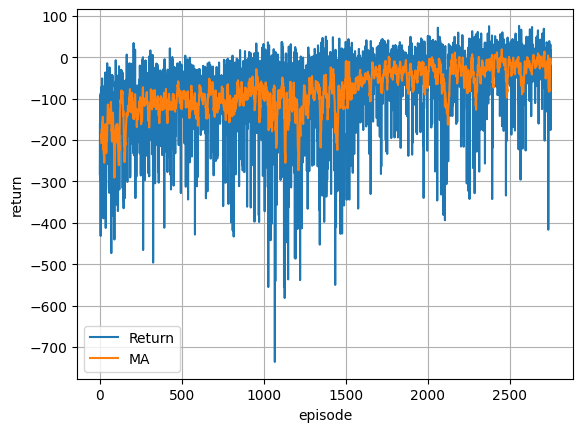

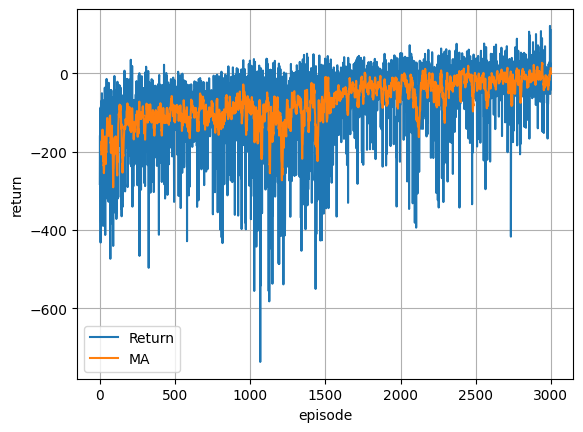

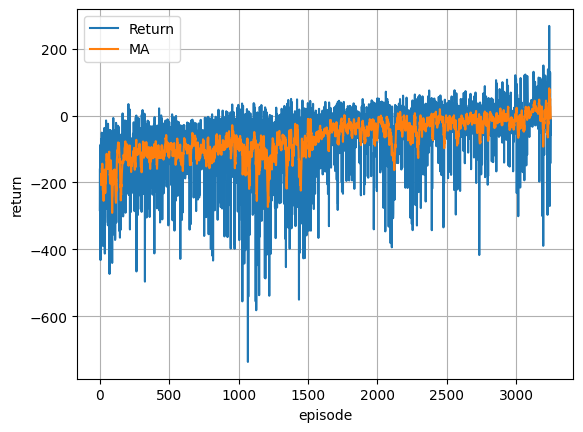

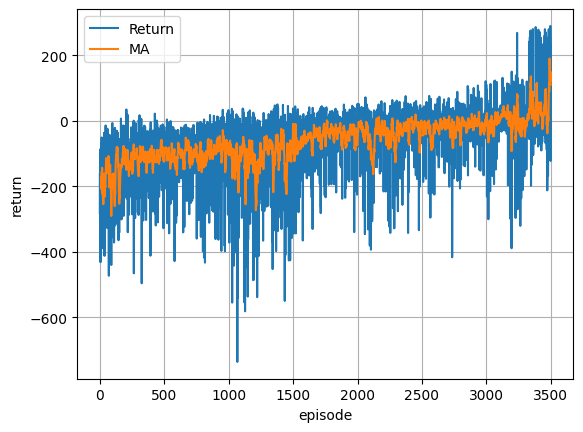

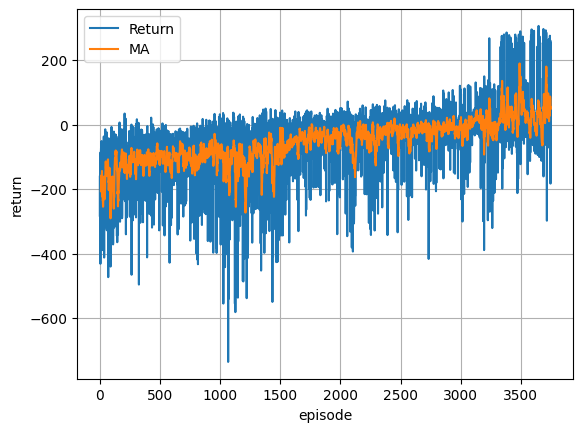

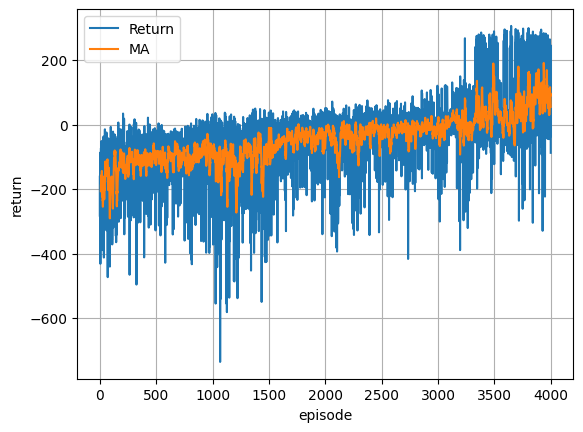

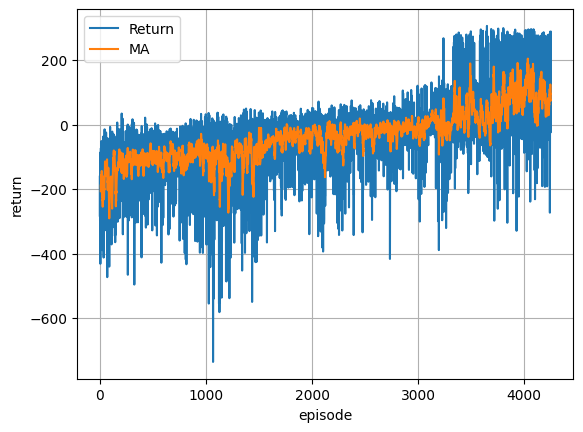

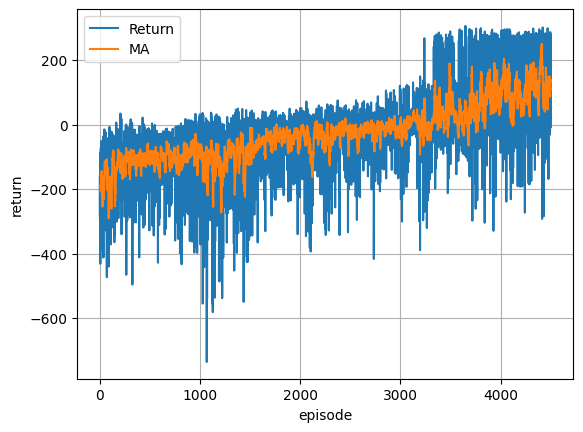

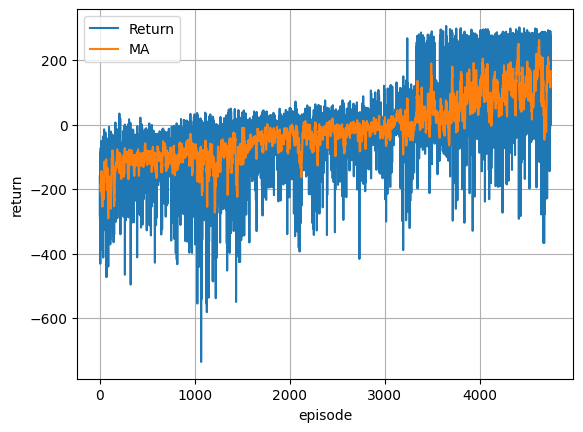

In [5]:
alpha_policy = 1e-5
gamma = 0.99
nb_episodes = 5000

env = gym.make("LunarLander-v2",
                continuous=True,
              render_mode = "rgb_array")
return_history = []

optimizer = tf.optimizers.Adam(learning_rate=alpha_policy)

for j in tqdm(range(nb_episodes)):
    k = 0
    accumulated_rewards = 0
    
    states = []
    actions = []
    rewards = []
    probs_log = []
    
    state, _ = env.reset()
    state = state.reshape(1, -1)
    
    with tf.GradientTape() as tape:
        while True:
            # env.render()        
            k += 1
            
            ### BEGIN SOLUTION

            ### STEP)
            
            feature_state = featurizer.transform(state)
            mu, sigma = policy(feature_state)

            action = np.random.multivariate_normal(mean=mu.numpy().ravel(), 
                                                   cov=sigma.numpy())

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            probs_log.append(loglikelyhoodGaussian(np.reshape(action, (-1, 1)), mu, sigma))

            accumulated_rewards += reward  
            state = next_state.reshape(1, -1)
            if done:
                if j % 250 == 0 and j != 0:
                    plt.plot(return_history, label='Return')
                    plt.plot(pd.Series(return_history, name='reward_history').rolling(10).mean(), label='MA')
                    plt.xlabel('episode')
                    plt.ylabel('return')
                    plt.grid(True)
                    _=plt.legend()
                    plt.show()
                return_history.append(accumulated_rewards)
                break   

        ### LEARN
        
        rewards = np.array(rewards)
        g_returns = [np.sum(gamma**np.arange(len(states)-i)*rewards[i:]) 
                        for i in range(len(states))]

        g_returns = tf.cast(g_returns, tf.float32)
        policy_loss = tf.reduce_mean(-tf.squeeze(probs_log)*g_returns)

    policy_gradients = tape.gradient(policy_loss, policy.trainable_variables) 
    optimizer.apply_gradients(zip(policy_gradients, policy.trainable_variables))        
        
    env.close()
    
    ### END SOLUTION
    

Plot the learning curve of the training process!

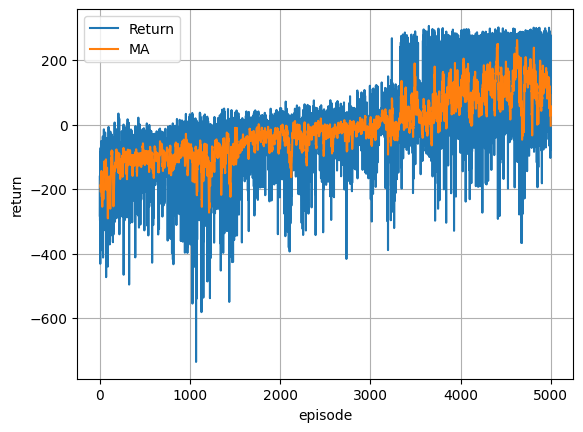

In [6]:
plt.plot(return_history, label='Return')
plt.plot(pd.Series(return_history, name='reward_history').rolling(10).mean(), label='MA')
plt.xlabel('episode')
plt.ylabel('return')
plt.grid(True)
_=plt.legend()

## Execution

Use `deterministic` to choose between deterministic execution (applying $\mu$ directly) or taking the stochastic action by sampling from the normal distribution.

In [8]:
env = gym.make("LunarLander-v2",
                continuous=True,
              render_mode="human")

deterministic = True

for j in tqdm(range(10)):
        
    state, _ = env.reset()
    accumulated_rewards = 0
    
    while True:        
        ### STEP)
        feat_state = featurizer.transform(np.reshape(state, (1, -1)))
        mu, sigma = policy(feat_state)
        if deterministic:
            action = np.reshape(mu.numpy(),(-1,))
        else:
            action = np.random.multivariate_normal(mean=np.squeeze(mu.numpy()), cov=sigma.numpy())
            
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
            
        accumulated_rewards += reward 

        state = next_state

        if done:
            if j % 1 == 0:
                print(f"Episode {j}, Length: {k}")
                print(f"Return {accumulated_rewards}")
                print()
            break            
        
env.close()
    
    

  0%|          | 0/10 [00:00<?, ?it/s]

Episode 0, Length: 70
Return -169.60167568331678

Episode 1, Length: 70
Return -46.47171451034421

Episode 2, Length: 70
Return -45.95270281963978

Episode 3, Length: 70
Return -38.03251956540942

Episode 4, Length: 70
Return 6.4801941262215905

Episode 5, Length: 70
Return -19.57715342807255

Episode 6, Length: 70
Return -37.954108332010634

Episode 7, Length: 70
Return -11.798448643490957

Episode 8, Length: 70
Return -43.18044924195591

Episode 9, Length: 70
Return -53.941313246584535



## 2) Actor-Critic with TD(0) Targets

Write an actor-critic (AC) algorithm to land the lander in the landing zone :)


Use the following cell to create two function approximators. One to estimate the state values (critic) and one to decide on the actions to take (actor). 

In [15]:
env = gym.make("LunarLander-v2",
                continuous=True,
              render_mode = "rgb_array")

state = np.reshape(env.reset()[0], (1, -1))
input_dim = len(featurizer.transform(state)[0])
action_space_dim = len(env.action_space.sample())

# define critic
def create_critic():
    critic = Sequential()
    critic.add(Dense(400, activation='linear', input_dim=input_dim))
    critic.add(tf.keras.layers.LeakyReLU(alpha=0.1))
    critic.add(Dense(400, activation='linear'))
    critic.add(tf.keras.layers.LeakyReLU(alpha=0.1))
    critic.add(Dense(1, activation='linear'))
    
    return critic

critic = create_critic()
w = critic.get_weights()
for i in range(len(w)):
    w[i] = w[i] * 0.2
critic.set_weights(w)

# define actor
def create_actor():
    input_layer = Input(shape=input_dim)
    
    hidden1 = Dense(400, activation='linear')(input_layer)
    hidden1 = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden1)
    
    hidden2 = Dense(400, activation='linear')(hidden1)
    hidden2 = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden2) 
    
    mu = Dense(action_space_dim, activation='linear')(hidden2)
    mu = Lambda(lambda x: tf.reshape(tf.clip_by_value(x, -1, 1), (-1, 1)))(mu)
    
    sigma = Dense(action_space_dim, activation='softplus')(hidden2)
    sigma = Lambda(lambda x: tf.linalg.diag(tf.clip_by_value(tf.reshape(x @ np.array([[0.01,   0], [   0, 0.1]]), [-1]), 1e-4, 1)))(sigma)

    actor = Model(inputs=input_layer, outputs=[mu, sigma])
    
    return actor

actor = create_actor()
theta = actor.get_weights()
for i in range(len(theta)):
    theta[i] = theta[i] * 0.4
actor.set_weights(theta)

env.close()

Use the following template to write an AC algorithm.

  0%|          | 0/2000 [00:00<?, ?it/s]

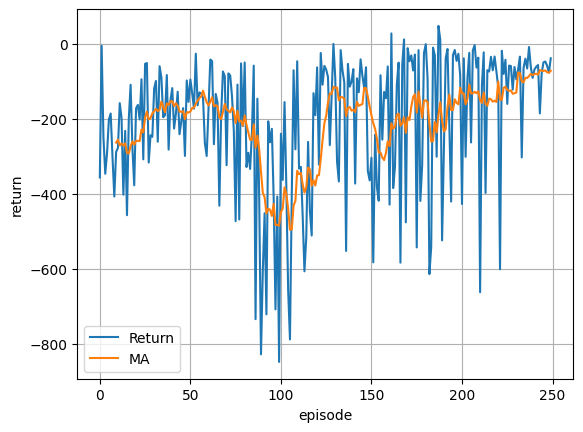

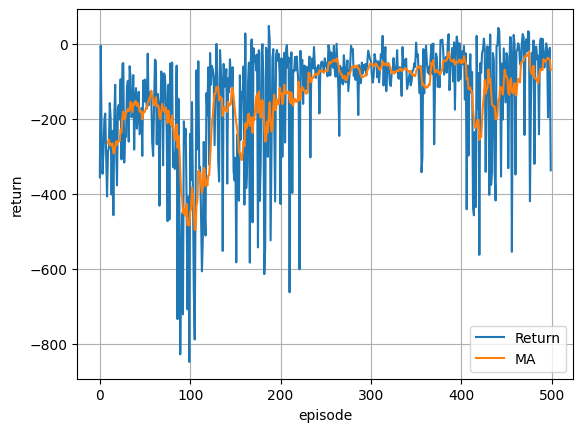

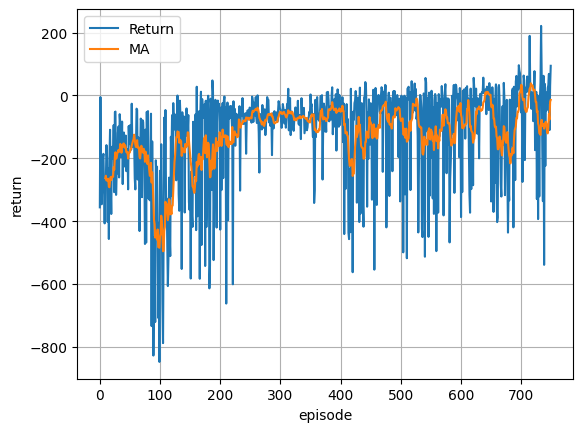

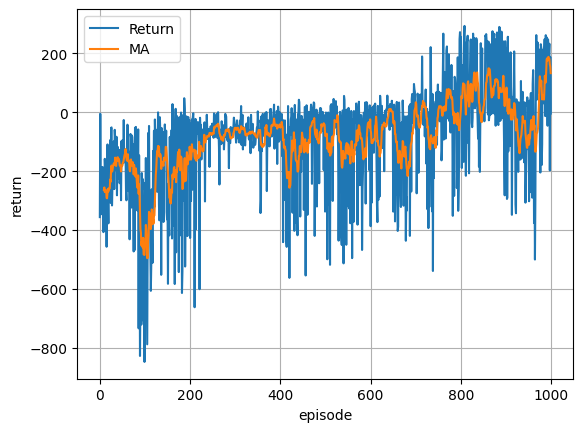

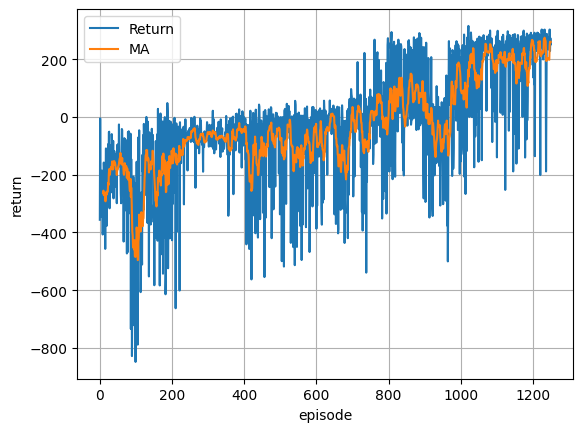

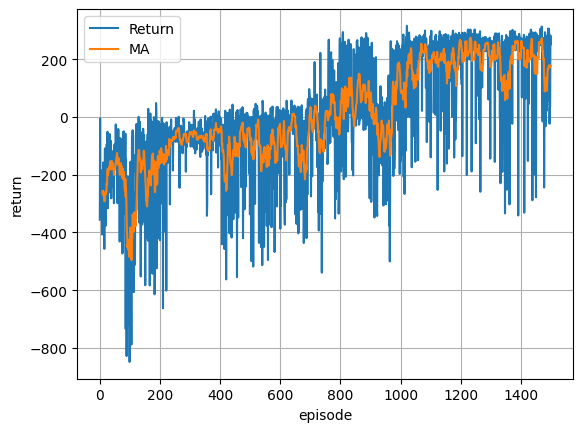

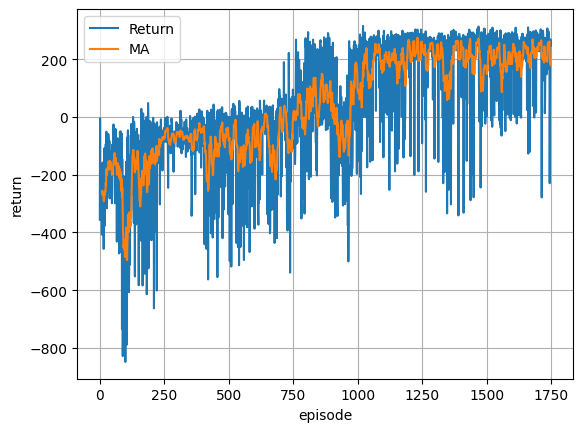

In [16]:
alpha_critic = 1e-4
alpha_actor = 1e-5
gamma = 0.99
nb_episodes = 2000
env = gym.make("LunarLander-v2",
                continuous=True,
              render_mode = "rgb_array")

return_history = []

for j in tqdm(range(nb_episodes)):
    k = 0
    accumulated_rewards = 0
    
    state, _ = env.reset()
    I = 1
    
    while True:
        # env.render()        
        k += 1
        
        with tf.GradientTape(persistent=True) as tape: 
            # persistent means the tape is not deleted after the first gradient has been computed
            
            ### BEGIN SOLUTION
            
            ### STEP)
            feat_state = featurizer.transform(np.reshape(state, (1, -1)))
            mu, sigma = actor(feat_state) 
            
            action = np.random.multivariate_normal(mean=np.squeeze(mu.numpy()), cov=sigma.numpy())
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            next_feat_state = featurizer.transform(np.reshape(next_state, (1, -1)))
            
            accumulated_rewards += reward  
            
            ### LEARN                   
            this_value = critic(feat_state)
            next_value = critic(next_feat_state)
            if not done:
                delta = reward + gamma * next_value - this_value  
            else:
                delta = reward - this_value  
            
            critic_loss = this_value
            
            action = np.reshape(action, (2, -1))
            actor_loss = loglikelyhoodGaussian(action, mu, sigma)

        # calculate and apply the gradients dMSE/dw
        critic_gradients = tape.gradient(critic_loss, critic.trainable_variables)
        actor_gradients = tape.gradient(actor_loss, actor.trainable_variables)
        
        w = critic.get_weights()        
        theta = actor.get_weights()
        
        for i in range(len(w)):
            w[i] += alpha_critic * np.squeeze(delta) * critic_gradients[i]

        for i in range(len(theta)):
            theta[i] += alpha_actor * I * np.squeeze(delta) * actor_gradients[i]
            
        critic.set_weights(w)
        actor.set_weights(theta)
        
        I = gamma * I
        state = next_state
        
        ### END SOLUTION

        if done:
            if j % 250 == 0 and j != 0:
                plt.plot(return_history, label='Return')
                plt.plot(pd.Series(return_history, name='reward_history').rolling(10).mean(), label='MA')
                plt.xlabel('episode')
                plt.ylabel('return')
                plt.grid(True)
                _=plt.legend()
                plt.show()
            return_history.append(accumulated_rewards)
            break            
        
    env.close()
    

Plot the learning curve of the training process!


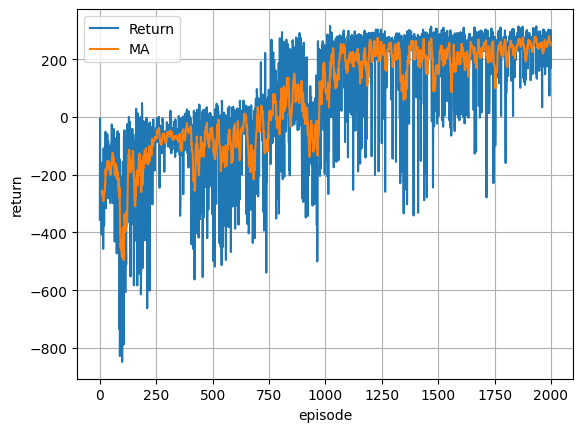

In [17]:
plt.plot(return_history, label='Return')
plt.plot(pd.Series(return_history, name='reward_history').rolling(10).mean(), label='MA')
plt.xlabel('episode')
plt.ylabel('return')
plt.grid(True)
_=plt.legend()

## Execution

Use `deterministic` to choose between deterministic execution (apply $\mu$) directly or take the stochastic action by sampling from the normal distribution.

In [19]:
env = gym.make("LunarLander-v2",
                continuous=True,
                render_mode="human")

deterministic = False

for j in tqdm(range(10)):
        
    state,_ = env.reset()
    accumulated_rewards = 0
    
    while True:
        ### STEP)
        feat_state = featurizer.transform(np.reshape(state, (1, -1)))
        mu, sigma = actor(feat_state)
        
        if deterministic:
            action = np.reshape(mu.numpy(), (-1,))
        else:
            action = np.random.multivariate_normal(mean=np.squeeze(mu.numpy()), cov=sigma.numpy())
            
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
            
        accumulated_rewards += reward 

        state = next_state

        if done:
            print(f"Episode {j}, Length: {k}")
            print(f"Return {accumulated_rewards} \n")
            break            
        
env.close()
    

  0%|          | 0/10 [00:00<?, ?it/s]

Episode 0, Length: 271
Return 264.9039383599296 

Episode 1, Length: 271
Return 131.32172663848021 

Episode 2, Length: 271
Return 178.2441081517323 

Episode 3, Length: 271
Return 280.8850370319889 

Episode 4, Length: 271
Return 272.2521931826646 

Episode 5, Length: 271
Return 272.17136261032124 

Episode 6, Length: 271
Return 314.60984981056305 

Episode 7, Length: 271
Return 249.06868511176359 

Episode 8, Length: 271
Return 166.20376015242837 

Episode 9, Length: 271
Return 244.4614608062243 

